In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import seaborn as sns
import scipy.optimize as optim
from matplotlib.animation import FuncAnimation

In [2]:
# Parse files

In [3]:
def load_vna_data(data_loc, date_str, antenna_str_list):
    data =[]
    for item in os.listdir(data_loc): # look through the cres_probe dir.
        for ant in antenna_str_list:
            if item == date_str + '_' + ant: # check if the item matches the date and antenna.
                antenna_name = ant
                measurement_loc = os.path.join(data_loc, item)
                for run in os.listdir(measurement_loc):
                    if os.path.isdir(os.path.join(measurement_loc, run)):
                        run_num = int(run.split('run')[-1])
                        run_loc = os.path.join(measurement_loc, run)
                        # read metadata
                        with open(os.path.join(run_loc,'meta/meta.txt')) as infile:
                            reader = csv.reader(infile)
                            for i, line in enumerate(reader):
                                if i==1:
                                    run_rad = float(line[0])
                                    run_z_offset = float(line[1])
                        ##
                        for meas in os.listdir(run_loc):
                            if os.path.isfile(os.path.join(run_loc, meas)) and meas != '.DS_Store':
                                #print(meas)
                                angle = int(meas.split('.')[0])
                                #print(angle)
                                csv_file = os.path.join(run_loc, meas)
                                # read csv data file
                                with open(csv_file) as infile:
                                    reader = csv.reader(infile)
                                    for i, line in enumerate(reader):
                                        if i == 6:
                                            labels = line
                                            #print(line)
                                            N_sparams = (len(labels) - 1) // 2
                                            sparams = []
                                            for n in range(N_sparams):
                                                sparams.append(labels[2 * n + 1].split('(')[0])
                                        if i > 6 and len(line) > 1:
                                            entry = {'antenna': antenna_name, 'run': run_num, 'radius': run_rad,
                                                     'z_offset': run_z_offset, 'angle': angle}
                                            for n, key in enumerate(labels):
                                                #print(key)
                                                entry.update({key: float(line[n])})
                                            for n, sparam in enumerate(sparams):
                                                entry.update({sparam + '(MAG)': 10 * np.log10(float(line[2 * n + 1]) ** 2 + float(line[2 * n + 2]) ** 2)})
                                                entry.update({sparam + '(PHASE)': np.arctan2(
                                                                        float(line[2 * n + 2]), float(line[2 * n + 1]))})
                                            data.append(entry)
    return pd.DataFrame(data)

def load_translation_data(path):
    data =[]
    for item in os.listdir(path): # look through the cres_probe dir.
        if os.path.isfile(os.path.join(path, item)) and item != '.DS_Store':
                measurement_path = os.path.join(path, item)
                dist = int(item.split('.')[0])

                # read csv data file
                with open(measurement_path) as infile:
                    reader = csv.reader(infile)
                    for i, line in enumerate(reader):
                        if i == 6:
                            labels = line
                            #print(line)
                            N_sparams = (len(labels) - 1) // 2
                            sparams = []
                            for n in range(N_sparams):
                                sparams.append(labels[2 * n + 1].split('(')[0])
                        if i > 6 and len(line) > 1:
                            entry = {'d': dist}
                            for n, key in enumerate(labels):
                                #print(key)
                                entry.update({key: float(line[n])})
                            for n, sparam in enumerate(sparams):
                                entry.update({sparam + '(MAG)': 10 * np.log10(float(line[2 * n + 1]) ** 2 + float(line[2 * n + 2]) ** 2)})
                                entry.update({sparam + '(PHASE)': np.arctan2(
                                                        float(line[2 * n + 2]), float(line[2 * n + 1]))})
                            data.append(entry)
    return pd.DataFrame(data)
    

In [10]:
data_loc = '/Users/ziegler/iCloud/Documents/data/cres_probes'
date_str = '210602'
antenna_str = ['dipole2']
plot_sparams = ['S24']
plot_rads = [10.0]
plot_z = [0.0]
plot_runs = [2]

data_list = []

data_pd = load_vna_data(data_loc, date_str, antenna_str)
frequencies = data_pd['Freq(Hz)'].unique()
xdata = np.radians(np.sort(data_pd['angle'].unique()))


for i, f in enumerate(frequencies):
    temp_data = data_pd[(data_pd['antenna'].isin(antenna_str)) & (data_pd['radius'].isin(plot_rads)) & 
                    (data_pd['run'].isin(plot_runs)) & (data_pd['Freq(Hz)'].isin([f]))]
    
    
    x = np.array(temp_data['angle'])
    y = np.array(temp_data['S24(MAG)'])
    y = y[np.argsort(x)]
    data_list.append(y)

data_list = np.array(data_list)



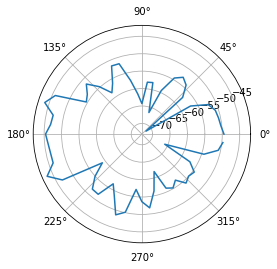

In [11]:
fig = plt.figure() 
ax = plt.subplot(111, polar=True)

ax.plot(xdata, data_list[3000, :])

MovieWriter ffmpeg unavailable; using Pillow instead.


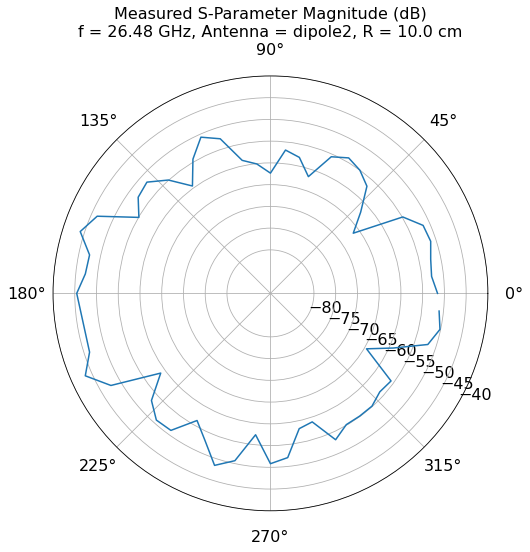

In [14]:
fig = plt.figure(figsize=(8,8)) 
ax = plt.subplot(111, polar=True)

rticks = np.arange(-80, -35, 5)
#rticklabels = np.arange(-90, -40, 10)

x = xdata
line, = ax.plot(x, data_list[0,:])
ax.set_ylim(-90, -40)
ax.set_rticks(rticks)
ax.tick_params(size=16, labelsize=16)
ax.set_rlabel_position(-30)
#ax.set_ylabel()

def animate(i):
    line.set_ydata(data_list[i, :])  # update the data.
    ax.set_title(f'Measured S-Parameter Magnitude (dB)\nf ={frequencies[i]*1e-9: 2.2f} GHz, Antenna = {antenna_str[0]}, R = {plot_rads[0]} cm', size=16)
    return line,


ani = FuncAnimation(
    fig, animate, frames=np.arange(2216, 3200, 16), blit=True, interval=60)
ani.save('/Users/ziegler/plots/210602_dipole2_monopole2_hf.gif')
#ani.save('/Users/ziegler/plots/test_movie.gif')
plt.show()

In [135]:
(3200-2216) / 4

246.0

In [351]:
data_loc = '/Users/ziegler/iCloud/Documents/data/cres_probes'
date_str = '210521'
antenna_str = ['loop2']
plot_sparams = ['S24']
plot_rads = [10.0]
plot_z = [0.0]
plot_runs = [1]

data_list = []

data_pd = load_vna_data(data_loc, date_str, antenna_str)
frequencies = data_pd['Freq(Hz)'].unique()
xdata = np.radians(np.sort(data_pd['angle'].unique()))

shift = np.argmin(abs(xdata - np.radians(258-360)))
shift_correction = 20 + 18

for i, f in enumerate(frequencies):
    temp_data = data_pd[(data_pd['antenna'].isin(antenna_str)) & (data_pd['radius'].isin(plot_rads)) & 
                    (data_pd['run'].isin(plot_runs)) & (data_pd['Freq(Hz)'].isin([f]))]
    
    
    x = np.array(temp_data['angle'])
    y = np.array(temp_data['S24(PHASE)'])
    y = np.unwrap(y[np.argsort(x)])
    y = np.unwrap(np.roll(y, - shift + shift_correction))
    y -= y[0]
    
    data_list.append(np.degrees(y))

data_list = np.array(data_list)



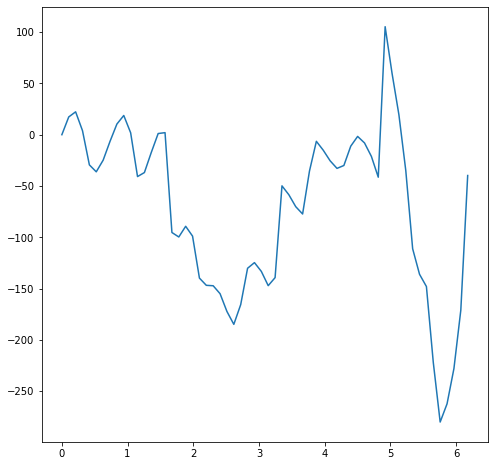

In [352]:
fig = plt.figure(figsize=(8,8))

ax = plt.subplot(111)
ax.plot(xdata, data_list[2700])


MovieWriter ffmpeg unavailable; using Pillow instead.


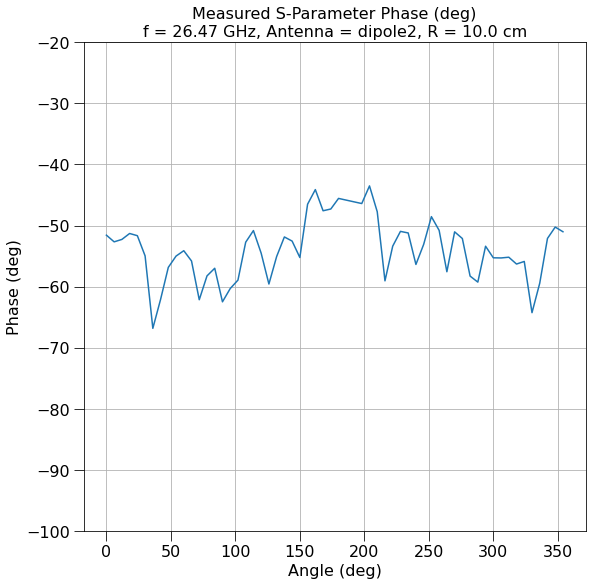

In [20]:
fig = plt.figure(figsize=(9,9)) 
ax = plt.subplot(111)

#rticks = np.arange(0, 4 * np.pi, np.pi/2)
#rticklabels = np.arange(-90, -40, 10)

x = np.degrees(xdata)
line, = ax.plot(x, data_list[0,:])
ax.set_ylim(-100,-20)
plt.grid()
#ax.set_rticks(rticks)
ax.tick_params(size=10, labelsize=16)
#ax.set_rlabel_position(-30)
ax.set_ylabel('Phase (deg)', size=16)
ax.set_xlabel('Angle (deg)', size=16)

def animate(i):
    line.set_ydata(data_list[i, :])  # update the data.
    ax.set_title(f'Measured S-Parameter Phase (deg)\nf ={frequencies[i]*1e-9: 2.2f} GHz, Antenna = {antenna_str[0]}, R = {plot_rads[0]} cm', size=16)
    return line,


ani = FuncAnimation(
    fig, animate, frames=np.arange(0, 3200, 16), blit=True, interval=60)
ani.save('/Users/ziegler/plots/210602_dipole2_monopole2_phase.gif')
#ani.save('/Users/ziegler/plots/test_movie.gif')
plt.show()